In [1]:
import cv2
import csv
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Conv2D, Dropout, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras import preprocessing
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
driving_log = pd.read_csv('data/driving_log.csv')
driving_log.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


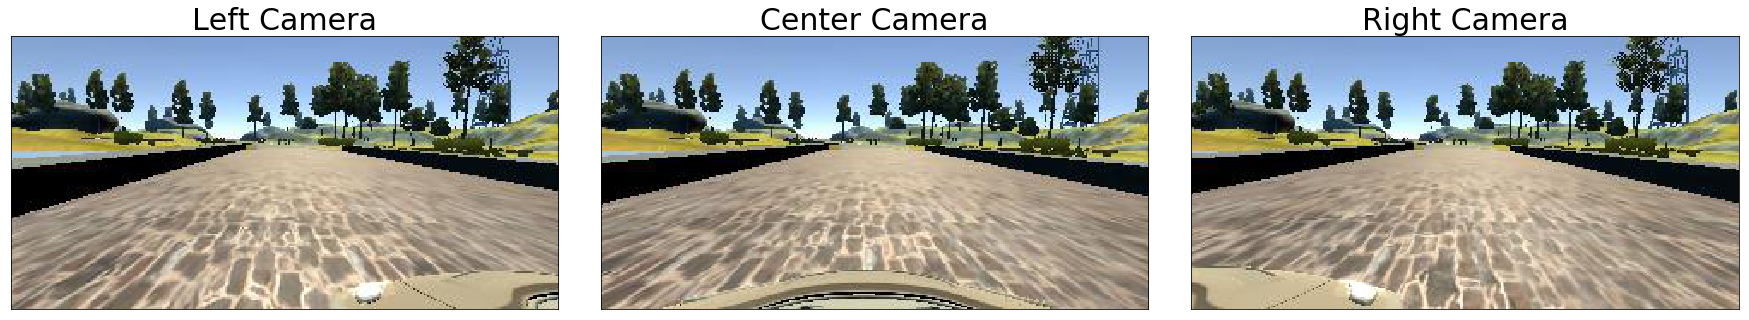

In [3]:
img = 'data/'+ driving_log["center"][0].strip()
originalImage = cv2.imread(img)
img_center = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)

img = 'data/'+ driving_log["left"][0].strip()
originalImage = cv2.imread(img)
img_left = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)

img = 'data/'+ driving_log["right"][0].strip()
originalImage = cv2.imread(img)
img_right = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_left)
ax1.set_title('Left Camera', fontsize=30)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax2.imshow(img_center)
ax2.set_title('Center Camera', fontsize=30)
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax3.imshow(img_right)
ax3.set_title('Right Camera', fontsize=30)
ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("training_img.png")

In [4]:
df_center = driving_log[["center", "steering"]].rename(columns={"center": "img_path"})
df_left = driving_log[["left", "steering"]].rename(columns={"left": "img_path"})
df_left["steering"] = df_left["steering"] + 0.2
df_right = driving_log[["right", "steering"]].rename(columns={"right": "img_path"})
df_right["steering"] = df_right["steering"] - 0.2
df_total = pd.concat([df_center, df_left, df_right], sort=False, ignore_index=True)

In [5]:
df_total['img_path'] = df_total['img_path'].str.replace('IMG/','')
df_total['img_path'] = df_total['img_path']

In [6]:
print('Total Images: {}'.format( len(df_total)))

Total Images: 24108


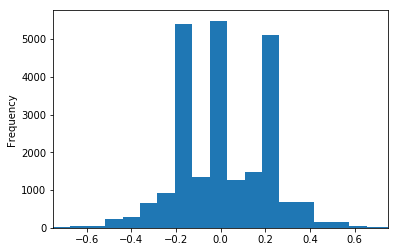

In [7]:
df_total['steering'].plot.hist(bins=30, xlim = (-0.75, 0.75))

In [8]:
train_samples, validation_samples = train_test_split(df_total, test_size=0.2)
print('Train samples: {}'.format(len(train_samples)))
print('Validation samples: {}'.format(len(validation_samples)))

Train samples: 19286
Validation samples: 4822


In [9]:
# KeyError: 'the label [0] is not in the [index]' solved after updating 
# pip install --upgrade git+git://github.com/keras-team/keras-preprocessing.git
datagen = preprocessing.image.ImageDataGenerator()
train_gen = datagen.flow_from_dataframe(dataframe=train_samples,
                                            directory="./data/IMG",
                                            x_col="img_path",
                                            y_col="steering",
                                            class_mode="other",
                                            target_size=(160, 320),
                                            batch_size=128)

Found 6421 validated image filenames.


C:\Users\rbaikejiang\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:269: UserWarning: Found 12865 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [10]:
valid_gen = datagen.flow_from_dataframe(dataframe=validation_samples,
                                            directory="./data/IMG",
                                            x_col="img_path",
                                            y_col="steering",
                                            class_mode="other",
                                            target_size=(160, 320),
                                            batch_size=128)

Found 1615 validated image filenames.


C:\Users\rbaikejiang\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:269: UserWarning: Found 3207 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [11]:
def createPreProcessingLayers():
    """
    Creates a model with the initial pre-processing layers.
    """
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((50,20), (0,0))))
    return model

In [12]:
def nVidiaModel():
    """
    Creates nVidea Autonomous Car Group model
    """
    model = createPreProcessingLayers()
    model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2)))
    model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2)))
    model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dropout(0.5))
    model.add(Dense(50))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Dense(1))
    return model

In [13]:
# Model creation
model = nVidiaModel()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 33, 64)         36928     
__________

In [14]:
# Compiling and training the model
STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_gen,
                                     validation_data=valid_gen,
                                     verbose=1,
                                     steps_per_epoch= STEP_SIZE_TRAIN,
                                     epochs = 50,
                                     validation_steps=STEP_SIZE_VALID)

Epoch 1/50
50/50 [==============================] - 88s 2s/step - loss: 0.0132 - val_loss: 0.0106
Epoch 2/50
50/50 [==============================] - 80s 2s/step - loss: 0.0110 - val_loss: 0.0100
Epoch 3/50
50/50 [==============================] - 83s 2s/step - loss: 0.0106 - val_loss: 0.0097
Epoch 4/50
50/50 [==============================] - 84s 2s/step - loss: 0.0106 - val_loss: 0.0091
Epoch 5/50
50/50 [==============================] - 82s 2s/step - loss: 0.0100 - val_loss: 0.0106
Epoch 6/50
50/50 [==============================] - 82s 2s/step - loss: 0.0097 - val_loss: 0.0085
Epoch 7/50
50/50 [==============================] - 81s 2s/step - loss: 0.0103 - val_loss: 0.0093
Epoch 8/50
50/50 [==============================] - 81s 2s/step - loss: 0.0092 - val_loss: 0.0097
Epoch 9/50
50/50 [==============================] - 81s 2s/step - loss: 0.0092 - val_loss: 0.0080
Epoch 10/50
50/50 [==============================] - 82s 2s/step - loss: 0.0091 - val_loss: 0.0098
Epoch 11/50
50/50 [

In [15]:
model.save('model_0328.h5')
print(history_object.history.keys())
print('Loss')
print(history_object.history['loss'])
print('Validation Loss')
print(history_object.history['val_loss'])

dict_keys(['val_loss', 'loss'])
Loss
[0.01324290657415986, 0.011002819037253454, 0.010678492910182052, 0.010623057559635754, 0.010030241019819, 0.009474340929276383, 0.009982063873522557, 0.009193954806690203, 0.00925982115158612, 0.00907627690595899, 0.008902147157085462, 0.008524133648735796, 0.008804859709833454, 0.008112511558725485, 0.008192023361019166, 0.007362138088653449, 0.00808586005178299, 0.007149559488745272, 0.0070750429719744524, 0.007191690742992008, 0.00733839456674529, 0.006449345091999231, 0.006902613504894105, 0.0060390419266489305, 0.0067559531681925114, 0.005865637770482917, 0.00564795810779287, 0.005225875840500002, 0.00479925226962708, 0.004703651907521241, 0.004306854405060787, 0.0042350122108096525, 0.00387087822302758, 0.004484498813859651, 0.004259136596181939, 0.0036927472536440126, 0.0037017402779467813, 0.003597054671327144, 0.0032248793518528563, 0.003065337804713666, 0.0031575730917956066, 0.0028525821993507215, 0.002701679398920627, 0.0025638609469865

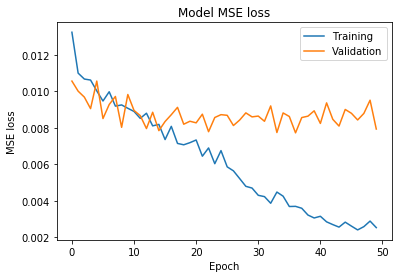

In [16]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('Model MSE loss')
plt.ylabel('MSE loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig("learning_curve.png")
plt.show()

In [17]:
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function

# Testing
test = img_center.reshape(1, 160,320,3) 
layer_outs = functor([test, 1.])
print(len(layer_outs))

15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


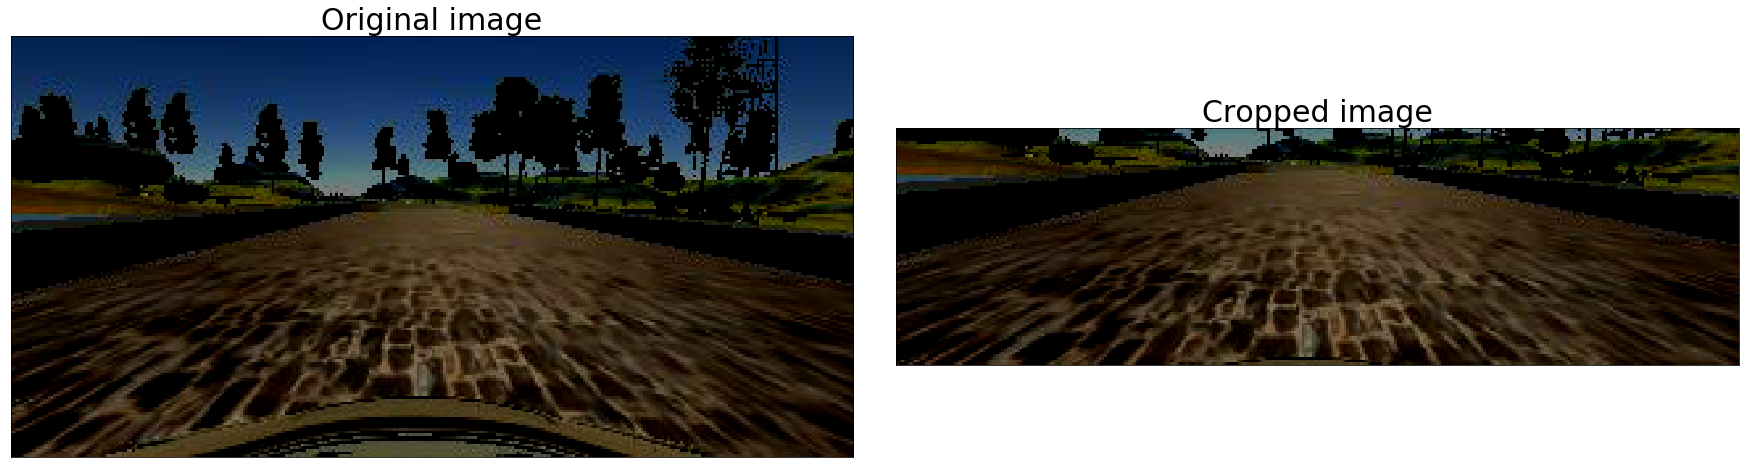

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow((np.squeeze(layer_outs[0])))
ax1.set_title('Original image', fontsize=30)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax2.imshow((np.squeeze(layer_outs[1])))
ax2.set_title('Cropped image', fontsize=30)
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("input_and_cropped.png")